# [NTDS'19] assignment 2: learning with graphs — solution
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `<your team number>`
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

The assignment is made of three parts:
1. [Spectral Graph Theory](#sgt)
1. [Regularization on graphs with Graph Signal Processing](#gsp)
1. [Machine Learning on Graphs](#ml)

<a id='sgt'></a>
## Part I: Spectral Graph Theory
### Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

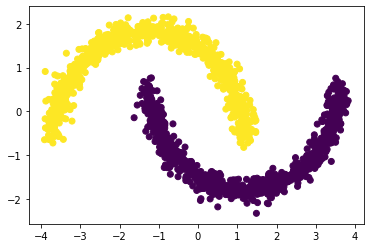

In [2]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [3]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    dist = squareform(pdist(X))
    adjacency = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adjacency[adjacency < epsilon] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

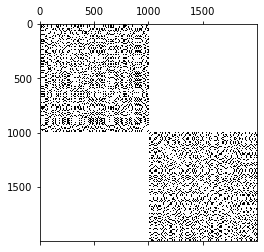

In [4]:
adjacency = epsilon_similarity_graph(X, sigma=0.5, epsilon=0.1)
plt.spy(adjacency)
plt.show()

How do you choose `sigma`?

**`sigma` reflects a typical (spatial) distance between the points. We want the graph to be connected but we also want it to have two clusters that would correspond to our data. One possible good strategy would be to start with average distance and then reduce it up to the point where we start seeing two separated clusters.**

How do you choose the threshold `epsilon`?

**`epsilon` is a sparsity parameter. Epsilon should be reasonably low to keep the weights that have a meaningful distribution (it should be wide enough or simply diverse in terms of values). A good strategy for choosing `epsilon` would be to plot the distribution of the weights and tune it accordingly. In this case, the value of `epsilon` should around `0.7`.**

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [5]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    combinatorial = D - adjacency
    if normalize:
        D_norm = np.diag(np.clip(np.sum(adjacency, 1), 1, None)**(-1/2))
        return D_norm @ combinatorial @ D_norm
    else:
        return combinatorial

In [6]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. 

Justify your choice of a solver for the eigendecomposition.

**We need a solver that works with real symmetric matrices. Also, we want the values to be sorted. `np.linalg.eigh` is a good choice since it satisfies both conditions.**

In [7]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    return np.linalg.eigh(laplacian)

In [8]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

#### Question 4: Interpretation
We plot the sorted eigenvalues as a function of their index:

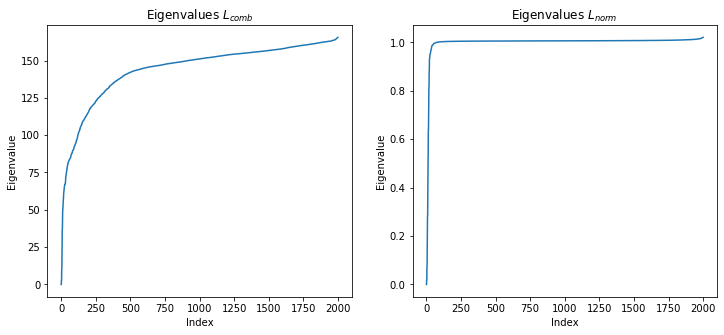

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

**For both, combinatorial and normalized, Laplacian matrices, the lowest eigenvalues $\lambda_0$ are 0 (technically, they are not exactly 0 due to a numerical error).**

**Here is a good detailed answer regarding eigenvectors (team 1):**

- <b>The eigenvector $u_{0}$ for the combinatorial laplacian:</b><br>
by the eigenvalue equation we have: $$L u_{0} = \lambda_{0} u_{0}$$
since $\lambda_{0}=0$, then: $$L u_{0} = 0$$
multiply by $u_{0}^{T}$ we get: $$u_{0}^{T} L u_{0} = u_{0}^{T} * 0 = 0$$
but the quadratic form of the combinatorial laplacian is given by: $$u_{0}^{T} L u_{0} = \sum_{(i, j) \in E} w_{i,j}(u_{0}[i] - u_{0}[j])^2$$
hence: $$\sum_{(i, j) \in E} w_{i,j}(u_{0}[i] - u_{0}[j])^2 = 0$$
for this to hold, $u_{0}[i] = u_{0}[j]$ for every edge $(i, j) \in E$. Then, $$u_{0} = c \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}$$
Therefore, the value of $u_{0}$ is the unit vector $e$.


- <b>The eigenvector $u_{0}^{'}$ for the normalized laplacian:</b><br>
if we follow the same argument as before, we have that $$(u_{0}^{'})^{T} L_{n} u_{0}^{'} = 0$$
since $$L_n = D^{-\frac{1}{2}} L D^{-\frac{1}{2}}$$
we get: $$(u_{0}^{'})^{T} D^{-\frac{1}{2}} L D^{-\frac{1}{2}} u_{0}^{'} = 0$$
as we shown this yields that $D^{-\frac{1}{2}} u_{0}^{'}$ is a unit vector $e$.<br>
Therefore, $u_{0}^{'} = D^{\frac{1}{2}} e$

When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

**Normalized. Eigenvalues of normalized Laplacian are bounded between 0 and 2 while eigenvalues of combinatorial Laplacian are unbounded and have values proportional to the size of a graph which might make further computations numerically unstable.**

#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [10]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    return np.count_nonzero(lamb <= threshold)

Tune the parameters $\epsilon$ and $\sigma$ of the similarity graph so that the graph is connected. Otherwise, clustering would be too simple!

In [11]:
print(compute_number_connected_components(lamb_norm, threshold=1e-12))

1


### Spectral clustering

Let us now see one application of spectral graph theory to clustering the two moon dataset.

#### Question 6: Baseline

As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

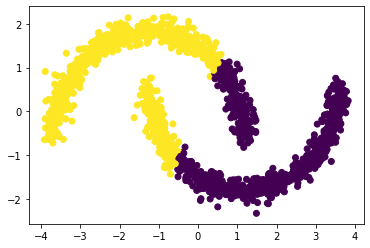

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

K-means cannot find a good solution to this problem. Why?

**K-means expects clusters that are convex and isotropic (i.e. roughly ball-shaped) and therefore performs poorly with the elongated shapes present in the dataset.**

#### Question 7: Spectral clustering

As opposed to naive K-means, spectral clustering doesn't operate on the input space but on the eigenspace of the graph that represents the data. Implement spectral clustering. You can use 
[this tutorial](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/tutoSC.pdf).

In [13]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method = KMeans(n_classes)
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency, self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        n_connected = compute_number_connected_components(self.e, threshold=1e-12)
        first_columns = self.U[:, :self.n_classes]
        if self.normalize:
            first_columns = first_columns / np.linalg.norm(first_columns, axis=1)[:, None]
        y_pred = self.clustering_method.fit_predict(first_columns)
        return y_pred

Connected components: 1


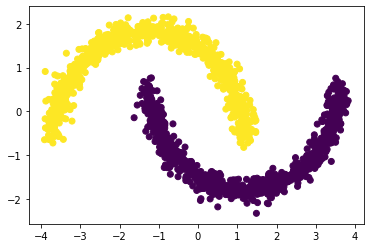

In [14]:
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

#### Question 8: On your dataset

Can you think of another 2D dataset in which k-means would badly perform, but spectral clustering would not?
Construct it!
For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

In [15]:
# borrowed from team #05 submission
def Smiley(N = 2000):
    """ return a 2D dataset representing a smiley with 4 classes (head, eyes, mouth) """
    # Head
    length = np.random.uniform(1.75, 2, size=int(2*N/5))
    angle = np.pi * np.random.uniform(0, 2, size=int(2*N/5))
    X_head = np.stack([length * np.cos(angle), length * np.sin(angle)], axis=1)
    Y_head = np.ones(X_head.shape[0])

    # eye 1
    length = np.random.uniform(0.1, 0.4, size=int(N/5))
    angle = np.pi * np.random.uniform(0, 2, size=int(N/5))
    X_eye1 = np.stack([-0.75 +length * np.cos(angle), 0.75 +length * np.sin(angle)], axis=1)
    Y_eye1 = 2*np.ones(X_eye1.shape[0])

    # eye 2
    length = np.random.uniform(0.1, 0.4, size=int(N/5))
    angle = np.pi * np.random.uniform(0, 2, size=int(N/5))
    X_eye2 = np.stack([0.75 +length * np.cos(angle), 0.75 +length * np.sin(angle)], axis=1)
    Y_eye2 = 3*np.ones(X_eye2.shape[0])

    # mouth
    length = np.random.uniform(1, 1.25, size=int(N/5))
    angle = np.pi * np.random.uniform(-0.15, -0.85, size=int(N/5))
    X_mouth = np.stack([length * np.cos(angle), -0.2 +length * np.sin(angle)], axis=1)
    Y_mouth = 4*np.ones(X_mouth.shape[0])

    X = np.concatenate([X_head, X_eye1, X_eye2, X_mouth], axis=0)
    Y = np.concatenate([Y_head, Y_eye1, Y_eye2, Y_mouth], axis=0)

    
    return X, Y

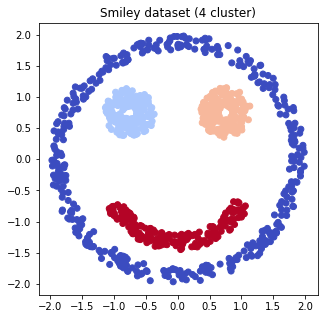

In [16]:
X_s, Y_s = Smiley(1000)
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(X_s[:, 0], X_s[:, 1], c=Y_s, cmap='coolwarm')
ax.set_title('Smiley dataset (4 cluster)')
plt.show()

Run K-means:

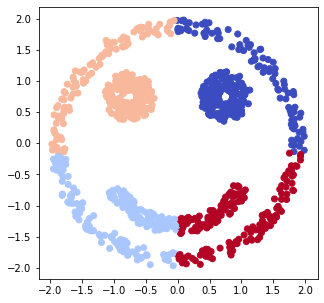

In [17]:
kmeans = KMeans(n_clusters=4)
y_pred_s = kmeans.fit_predict(X_s)
fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(X_s[:, 0], X_s[:, 1], c=y_pred_s, cmap='coolwarm')
plt.show()

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

Connected components: 1


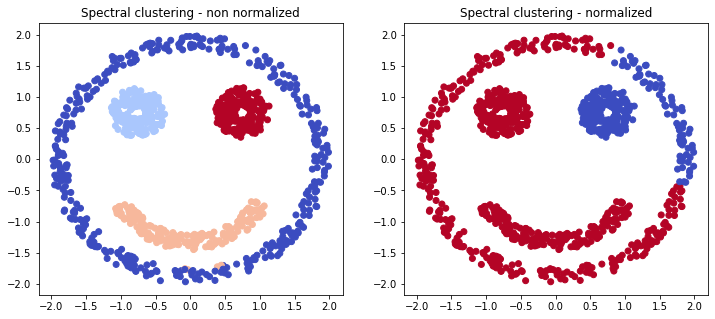

In [18]:
adjacency_s = epsilon_similarity_graph(X_s, sigma=0.3, epsilon=0.5)
lamb_norm_s, _ = spectral_decomposition(compute_laplacian(adjacency_s, normalize=True))
print("Connected components:", compute_number_connected_components(lamb_norm_s, threshold=1e-12))

# normalized
spectral_clustering_n = SpectralClustering(n_classes=4, normalize=True)
y_pred_s_norm = spectral_clustering.fit_predict(adjacency_s)

# non normalized
spectral_clustering = SpectralClustering(n_classes=4, normalize=False)
y_pred_s = spectral_clustering.fit_predict(adjacency_s)


fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(X_s[:, 0], X_s[:, 1], c=y_pred_s, cmap='coolwarm')
ax[0].set_title('Spectral clustering - non normalized')
ax[1].scatter(X_s[:, 0], X_s[:, 1], c=y_pred_s_norm, cmap='coolwarm')
ax[1].set_title('Spectral clustering - normalized')
plt.show()

**K-means also performs poorly on this dataset because of the non-convex/non-spherical clusters it contains. Spectral clustering works well regardless of normalization, provided the graph is constructed with the appropriate parameters $\sigma$ and $\epsilon$. The choice of those parameters is (again) crucial for spectral clustering to work as expected.**

### Dimensionality Reduction with Laplacian Eigenmaps

Most datasets are very high-dimensional, which means it can be very hard to understand their geometry. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to compare these techniques. Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset:

In [19]:
from utils import load_mnist

X_mnist, y_mnist = load_mnist()
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps

Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

Solution:

**Laplacian eigenmaps make the assumption that observations low on a low-dimensional possibly non linear manifold. They aim at preserving proximity of points on the manifold.**

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.
Solution (from team 3):

In [20]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    laplacian = compute_laplacian(adjacency, normalize)
    lamb, U = spectral_decomposition(laplacian)
    # number of connected components = number of zero eigenvalues, 
    # zero eigenvalues are associated with constant vectors 
    n_CC = compute_number_connected_components(lamb, threshold=1e-12)
    # only take columns associated with non-zero eigenvalues
    cols_to_take = range(n_CC, n_CC + dim + 1)
    coords = U[:, cols_to_take]
    
    return coords

Use this function to visualize MNIST in 2D. Feel free to play with the different parameters.

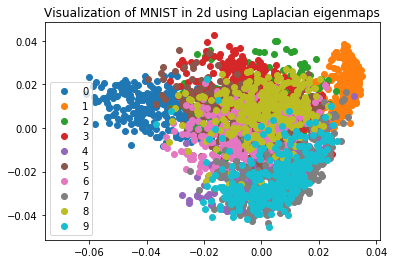

In [21]:
dim = 2
sigma = 2e3
epsilon = 0
normalize = True

X_2d = laplacian_eigenmaps(X_mnist, dim, sigma, epsilon, normalize)
for i in classes:
    mask = y_mnist == i
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=i)
plt.legend()
plt.title("Visualization of MNIST in 2d using Laplacian eigenmaps")
plt.show()

Visualize MNIST in 3D:

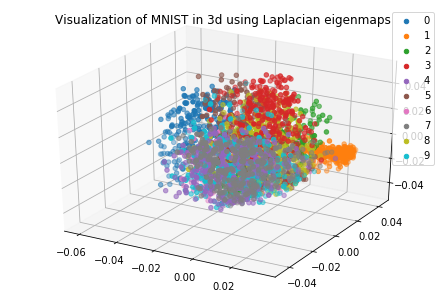

In [22]:
dim = 3
sigma = 2e3
epsilon = 0
normalize = True

X_3d = laplacian_eigenmaps(X_mnist, dim, sigma, epsilon, normalize)

fig = plt.figure()
ax = Axes3D(fig)
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2], label=i)
plt.legend()
plt.title("Visualization of MNIST in 3d using Laplacian eigenmaps")
plt.show()

#### Question 10: Comparison with other methods  
We provide the visualization of MNIST with other methods:

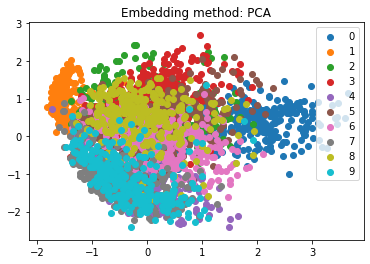

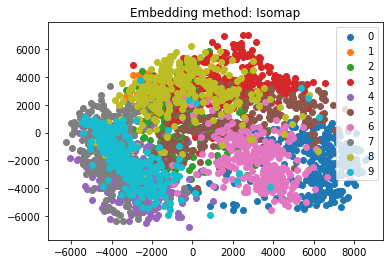

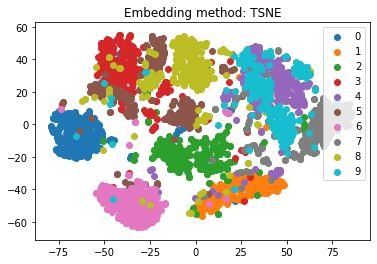

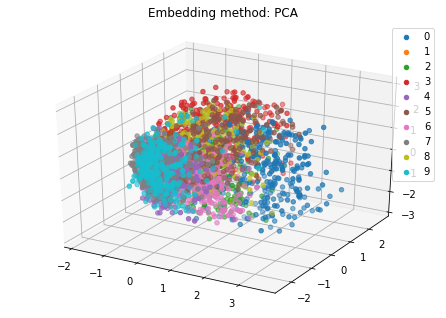

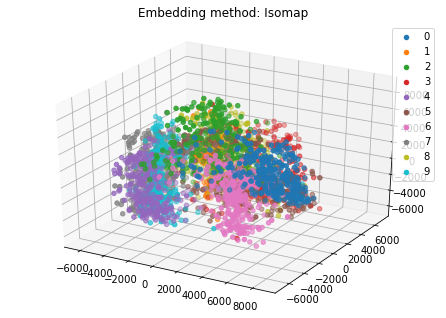

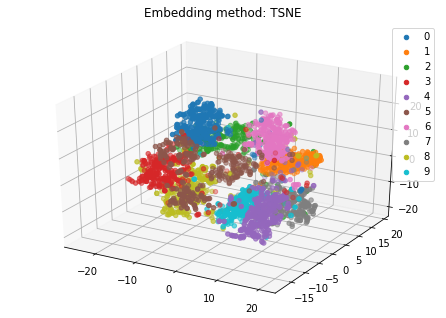

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# This cell can take a few minutes to run
run_this_cell = True

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        for i in classes:
            mask = y_mnist == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_mnist == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In a few words, what are the principles guiding the design of each method? Compare their results.

Solution (from team 3):

**PCA is a linear method that uses the $k$ largest singular values from the singular value decomposition (SVD) of the data matrix. These axes form the best linear subspace of dimension $k$ because the variance of the orthogonal projection of the data points is maximal on it.
It is the method of choice if the data can be summarized as _linear_ combinations of features.**

**Isomap is a non-linear method that starts with the conversion of the data matrix to a graph, then the shortest path matrix is computed, and the linear method _Multi-Dimensional Scaling_ method is applied on the shortest path matrix. The advantages of Isomap are that it is able to discover manifolds of arbitrary dimensionality and it is guaranteed to converge to the global optimal solution.
We can see that it produces a better separation of the classes than PCA on the MNIST dataset.**

**T-SNE is yet another non-linear method, which tries to circumvent the _crowding problem_, i.e. when a lot of data points are constrained in a small part of space. It does this by minimizing the divergence of distributions of the data points transformed into conditional probabilities and a measure of similarity between the new points in the sub-space $\mathbb{R}^k$. It usually produces better visualizations than the other methods thanks to its crowding-circumvention property, and we can see that it is the case here.**

<a id='gsp'></a>
## Part II: Regularization on graphs with Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing and regularization on graphs in general. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [24]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [25]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [26]:
def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)

    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)

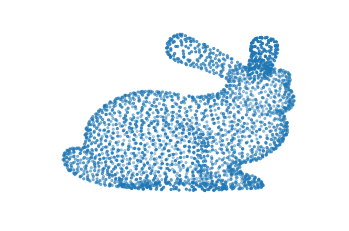

In [27]:
plt.subplot(111, projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [28]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)

Plot the eigenvalues.

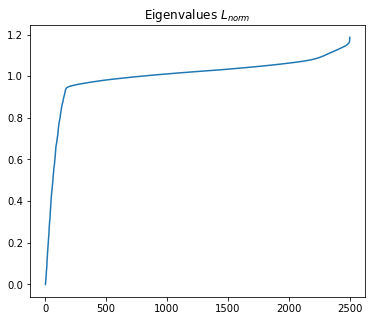

In [29]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

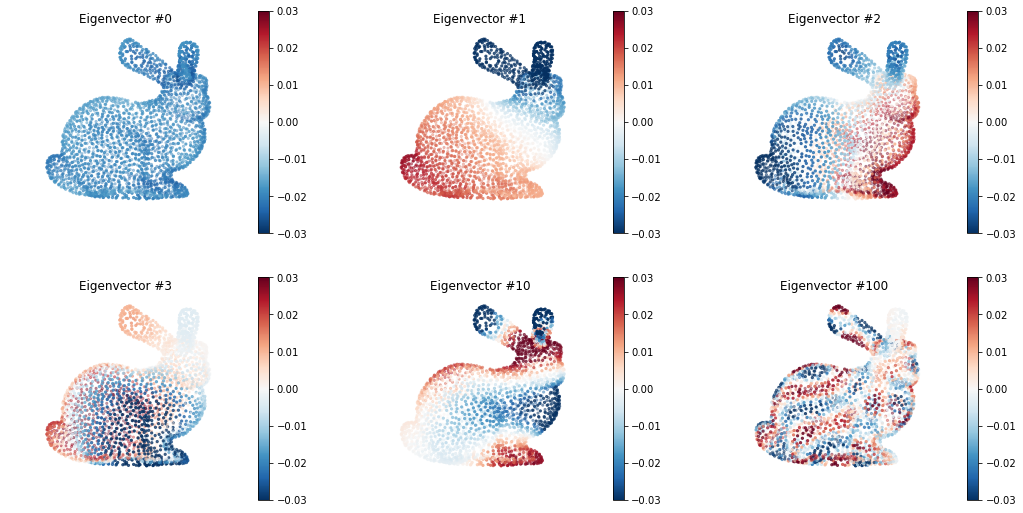

In [30]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

What can you say in terms of the variation (smoothness) of these signals? How can the smoothness of a signal be measured?

Solution:
**These signals become less and less smooth as the corresponding eigenvalue increases. In general, the inverse of the smoothness of a signal on a graph can be measured by the quadratic form of the Laplacian $x^T L X = \sum_{(i, j) \in \mathcal E} w_{i, j} \|x_i - x_j \|^ 2$. This quantity can also be seen as the square norm of the graph gradient.**

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform (GFT) of a graph signal and its inverse.
**Note**: You can assume that you have internal access to the eigendecomposition (`U` and `lam`) of the laplacian.

In [31]:
def GFT(signal: np.ndarray):
    return U.T @ signal

def iGFT(fourier_coefficients: np.ndarray):
    return U @ fourier_coefficients

Now, let's create a graph signal:

/home/michael/.conda/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


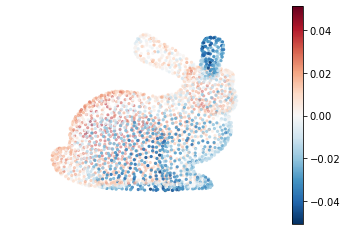

In [32]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3*noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

and plot its graph spectrum:

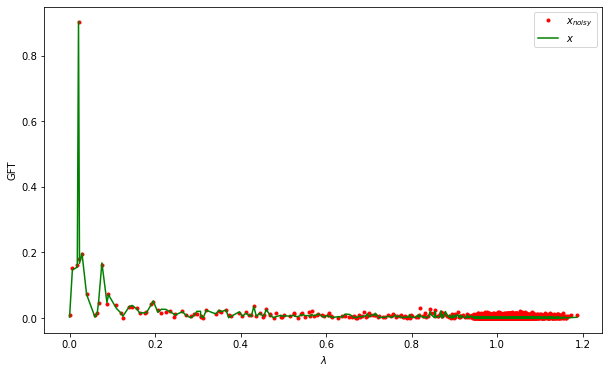

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(x_noisy)), 'r.') 
plt.plot(lam, np.abs(GFT(x)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x_{noisy}$', '$x$'])

#### Question 13: Graph filters

We will try to extract the signal from the noise using graph filters. Let us start by creating three ideal graph filters.

In [34]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

Additionally, create the ideal graph filter that implements the solution of Tikhonov regularization.

In [35]:
alpha = 0.99 / np.max(lam)

ideal_tk = np.ones((n_nodes,))
ideal_tk = 1 / (1 + alpha*lam)

Let's plot the spectral responses:

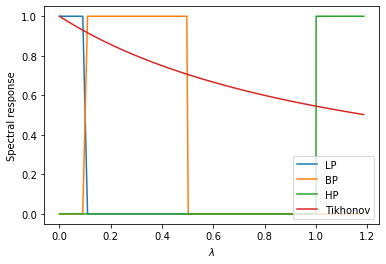

In [36]:
plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')

Create a function to filter a signal given an ideal graph filter

In [37]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    x_gft = GFT(x)
    filter_gft = x_gft * spectral_response
    return iGFT(filter_gft)

Let us visualize the results:

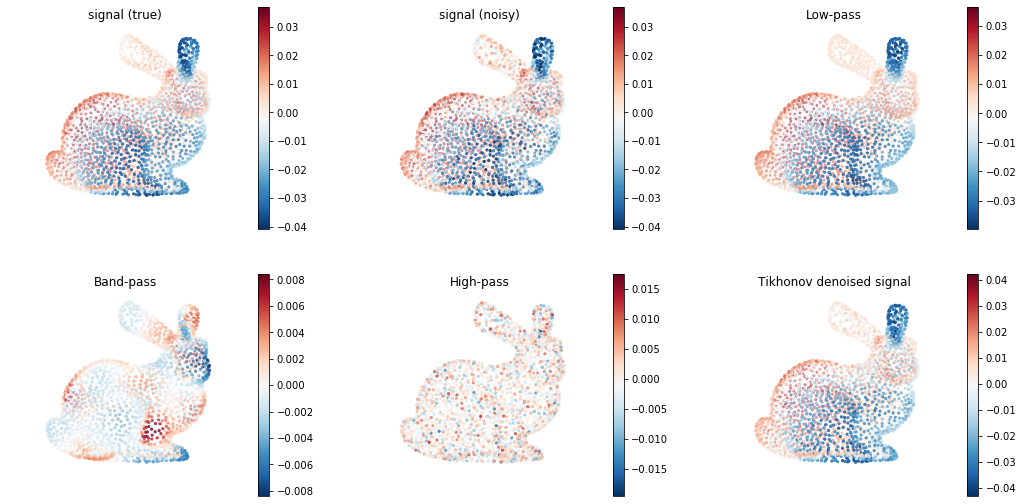

In [38]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_bp = ideal_graph_filter(x_noisy,ideal_bp)
x_hp = ideal_graph_filter(x_noisy,ideal_hp)
x_tk = ideal_graph_filter(x_noisy,ideal_tk)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

How would you link to the observations you made before about the spectral decomposition of the laplacian?
Also, judging from the results, what type of model prior do you think Tikhonov regularization enforces?

Solution: **Graph filtering as an operation that scales the coordinates of a graph signal in the basis given by the spectral decomposition of the laplacian. In this sense, a low pass filter only preserves the components associated with the smallest eigenvalues (and hence it smoothens the signal), a high pass filter preserves the components associated with the largest eignevalues (and hence it produces signals with rapid spatial variations), and a band pass filter preserves the components in between (and produces a mildly smooth signal).**

**Looking at the spectral response of the Tikhonov filter we see that it weights down the components associated with large eigenvalues, and preserves the low frequencies. We thus say that this is a low pass filter.**

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
(\lambda_0)^k &\dots & 0\\
\vdots & \ddots & \vdots\\
0 & \dots & (\lambda_N)^k
\end{bmatrix} U^T.
$$

This means that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k.$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right).$$

With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Implement a function to find the coefficients of a polynomial that approximates a given ideal filter.
**Hint:** `np.vander` and `np.linalg.lstsq`.

In [39]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    A = np.vander(lam, order, increasing=True)
    coeff = np.linalg.lstsq(A, spectral_response, rcond=None)[0]
    return coeff

Implement a function to compute the frequency response of that filter.

In [40]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    response = np.zeros_like(lam)
    for n, c in enumerate(coeff):
        response += c * (lam**n)
    return response

Let us fit the Tikhonov ideal filter with several polynomials of different order.

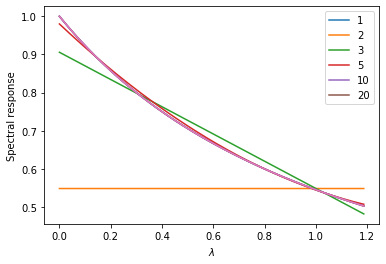

In [41]:
plt.plot(lam, ideal_tk)
orders = [1, 2, 3, 5, 10, 20]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_tk)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam))

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(orders)

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [42]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    power = np.eye(laplacian.shape[0])
    filt = coeff[0] * power
    for n, c in enumerate(coeff[1:]):
        power = laplacian @ power
        filt += c * power
    return filt

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [43]:
order = 3
coeff_tk = fit_polynomial(lam, order, ideal_tk)
g_tk = polynomial_graph_filter(coeff_tk, laplacian)

#### Question 15: ARMA filter

As you have seen in class, polynomial graph filters are only one of the ways in which you can approximate ideal graph filters. 
In this sense, ARMA filters are a natural way to implement Tikhonov denoising on graphs.
Let us recall the general solution of the Tikhonov regularized denoising problem 

$$y=(I+\alpha L)^{-1}x. $$

With a little bit of algebra manipulation we can rewrite this expression as
$$
    y = -\alpha L y + x,
$$
from which we can derive the iterative algorithm
$$
    y_k = -\alpha L y_{k-1} + x\qquad k=1,2,\dots
$$
which is guaranteed to converge as long as $\alpha \lambda_{max} < 1$.

Implement the ARMA version of Tikhonov regularization.

In [44]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    y = x
    for k in range(max_iter):
        y = - alpha * laplacian @ y + x
    return y

Filter the previous noisy graph signal with the polynomial and ARMA approximations of the ideal Tikhonov filter.

In [45]:
x_tk_polynomial = g_tk @ x_noisy
x_tk_arma = arma_tikhonov(x_noisy, laplacian, alpha)

Let us compare with the previous version.

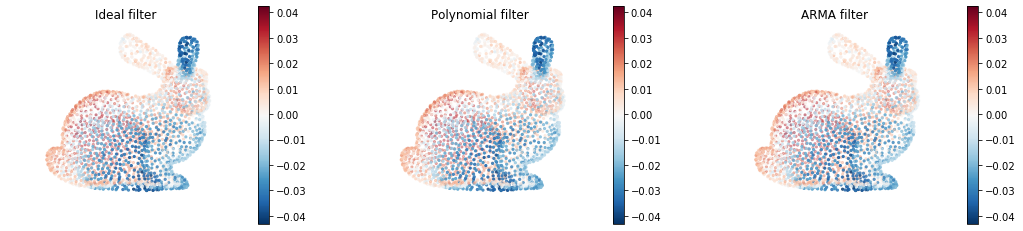

In [46]:
plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(x_tk, title='Ideal filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(132, projection='3d')
plot_bunny(x_tk_polynomial, title='Polynomial filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(133, projection='3d')
plot_bunny(x_tk_arma, title='ARMA filter', vlim=[min(x_tk), max(x_tk)])

<a id='ml'></a>
## Part III: Machine Learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [47]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library (DGL).

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph.
Our task is to design a classifier that uses these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs.
We assume that we know to which scientific field a small subset of the papers belongs (the ones contained in `train_mask`).
The goal is to predict to which field the other papers belong, using both the citation graph and the bag-of-word representation of each paper.

In [48]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]

For this exercise we will use the normalized laplacian.

In [49]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

#### Question 16: Logistic regression

The simplest classification method consists in ignoring the citation graph and trying to classify the papers using only the features.
In this case, the problem is viewed as a standard classification task.
To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them.
To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set.
And finally, we will test our classifier on the rest of the nodes.
**Hint:** use `sklearn.linear_model.LogisticRegression`.

In [50]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [51]:
log_reg = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg.fit(train_features, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
train_acc = log_reg.score(train_features, train_labels)
val_acc = log_reg.score(val_features, val_labels)
test_acc = log_reg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5967 | Test accuracy 0.6050


#### Question 17: Handcrafted graph filters

That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

**We can make the assumption that papers that are connected are similar, therefore making the associated signal smooth. The denoised signal here should then be made mostly of lower frequencies, and we will use a low-pass filter to create new features.**

Based on this prior, design an ideal filter response that you believe could enhance important features of the graph. 

**Note:** you just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note:** finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [53]:
alpha = 0.99 / lam_max

ideal_filter = np.ones((n_nodes,))
ideal_filter = 1 / (1 + alpha*lam)

Choose a filter order to approximate your filter using laplacian polynomials.

In [54]:
order = 5

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

Let's plot the frequency response of your spectral template and its polynomial approximation.

Text(0, 0.5, 'Spectral response')

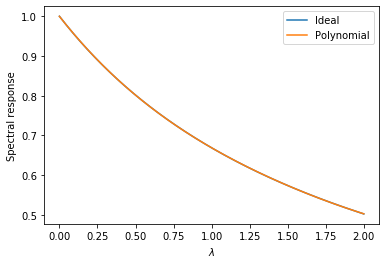

In [55]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

Now, let's create the new features.

In [56]:
filtered_features = graph_filter @ features.numpy()

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [57]:
log_reg = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg.fit(train_features, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Evaluate your model.

In [58]:
train_acc = log_reg.score(train_features, train_labels)
val_acc = log_reg.score(val_features, val_labels)
test_acc = log_reg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.7167 | Test accuracy 0.7000


#### Question 18: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as above, but instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful if you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [59]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [60]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

In [61]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

And train the classifier end to end.

In [62]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/home/michael/.conda/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/.conda/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.9459 | Val Accuracy 0.2667
Epoch 00001 | Time(s) nan | Train Loss 1.9221 | Val Accuracy 0.2533
Epoch 00002 | Time(s) nan | Train Loss 1.8533 | Val Accuracy 0.2467
Epoch 00003 | Time(s) 0.0687 | Train Loss 1.7058 | Val Accuracy 0.2700
Epoch 00004 | Time(s) 0.0521 | Train Loss 1.4878 | Val Accuracy 0.2900
Epoch 00005 | Time(s) 0.0459 | Train Loss 1.3438 | Val Accuracy 0.2967
Epoch 00006 | Time(s) 0.0418 | Train Loss 1.0504 | Val Accuracy 0.3067
Epoch 00007 | Time(s) 0.0394 | Train Loss 1.1285 | Val Accuracy 0.3167
Epoch 00008 | Time(s) 0.0387 | Train Loss 0.8329 | Val Accuracy 0.3200
Epoch 00009 | Time(s) 0.0378 | Train Loss 0.9067 | Val Accuracy 0.3167
Epoch 00010 | Time(s) 0.0375 | Train Loss 0.8401 | Val Accuracy 0.3133
Epoch 00011 | Time(s) 0.0368 | Train Loss 1.0514 | Val Accuracy 0.3133
Epoch 00012 | Time(s) 0.0367 | Train Loss 1.1378 | Val Accuracy 0.3300
Epoch 00013 | Time(s) 0.0372 | Train Loss 1.1666 | Val Accuracy 0.3200
Epoch 00014 | T

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learned.
Print the coefficients of the learned filter.

In [63]:
coeff_gcn = model.pol_weights.detach().numpy()
print(coeff_gcn)

[-12.998725   16.839718   -1.9868492  -2.7973063]


To interpret the model we can plot the frequency response of the learned filter.

Text(0, 0.5, 'Spectral response (db)')

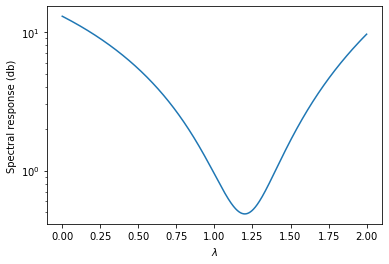

In [64]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

#### Question 19

As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor:

In [65]:
graph_gcn_filter = polynomial_graph_filter(coeff_gcn, laplacian)

Let's extract the new features by filtering the data:

In [66]:
features_gcn = graph_gcn_filter @ features.numpy()

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on these features:

In [67]:
log_reg_gcn = LogisticRegression(penalty='l2', multi_class="auto", solver="liblinear", C=1e4, fit_intercept=False, max_iter=1000)
log_reg_gcn.fit(train_features_gcn, train_labels)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Finally, let's evaluate this model:

In [68]:
train_acc = log_reg_gcn.score(train_features_gcn, train_labels)
val_acc = log_reg_gcn.score(val_features_gcn, val_labels)
test_acc = log_reg_gcn.score(test_features_gcn, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.7867 | Test accuracy 0.7890


The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

Solution :
**The model is the same in the two cases: it is a logistic regression composed with a Laplacian polynomial. However,  there are two differences:**
  * **The main one is that in the Pytorch code, the filters and the logistic regression are trained simulatenously (it is called end-to-end learning). In the code that uses Scikit learn, the logistic regression is learned separately, in a two-step process.**
  * **The optimizer is not the same in the two cases, and there are differences in the regularization as well. The Pytorch code uses Dropout and a l2 regularizer (the weight decay parameter in Adam) whereas Scikit learn only uses l2 regularization with another parameter value.**